## 008 Pilot passive joint choice-craving model alternatives in pymc (single subject)

Date: 24.Jul.2022

### Purpose

Implement model alternatives for passive joint choice-craving models.

### Naming convention
1. Passive - craving follows value update
2. RW - RW single update rule
3. EVRPE - momentary EV and RPE used to predict

### Outline of Plan

1. Rerun Passive_RW_EVRPE model
2. Implement Passive_RW_EV model
3. Implement Passive_RW_RPE model
4. Implement Passive_RWSeparate_EVRPE model
5. Implement Passive_RWSeparate_EV model
6. Implement Passive_RWSeparate_RPE model
7. Perform single-subject model comparison

### What we did in this notebook

1. Implemented all models listed above
2. Implemented normed craving versions of RW_EVRPE and RW_EV models. In these models, craving ratings are zscored. This also involves altering the priors for the weights. Weight_zero is changed from N(25, 3) to N(0, 1). Other weights are changed from N(0, 3) to N(0, 1). Might have to test a few versions of priors.
3. The EV model does much better than EVRPE model, which shouldn't be the case. This needs to be fixed in future iterations.
4. Plotted posterior predictive distribution for cravings. Need to plot posterior predictive distribution for actions as well.
5. Model comparison revealed that EV only model is the best performing one for this subject.
6. Need to find a way to assess combined WAIC for choice and craving model based on 'like' and 'craving_like' which are separate at the moment. Maybe I can plot them on a (like_d_waic x craving_like_d_waic) plot and calculate the distance from the origin as the overall fit.

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at
import aesara
from scipy import stats

from sys import path
import os

root_dir = "/Users/kulkarnik/LocalProjects/SlotsTasks/"
project_dir = f'{root_dir}/online/prolific-food-craving/'
model_functions_path = f'{root_dir}/bayesian_models/slotscraving/'

## Add model_functions to system path
path.append(model_functions_path)

from sepblock_decision.utils import load_data # type: ignore

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

## Load data

In [4]:
path_to_summary = f'{project_dir}/rawdata/clean_df_summary.csv'
path_to_longform = f'{project_dir}/rawdata/clean_df_longform.csv'
df_summary, longform = load_data.load_clean_dbs(path_to_summary, path_to_longform)
df_summary = df_summary[
    (df_summary['Money Accuracy']>0.4) & 
    (df_summary['Other Accuracy']>0.4)]
longform = longform[(longform['pid_db'].isin(df_summary['id'])) & (longform['Type']!='practice')]
pid_list = longform['PID'].unique()
longform

,PID,id,Block,Type,Trial,Cue Time,Action,Action Time,Reward,Reward Time,RT,Spin Speed,Craving Rating,Mood Rating,pid_db
5,61281debe85082cc937dd9ae,6,1,other,1,1.647963e+09,1,1.647963e+09,1,1.647963e+09,0.972,fast,-1.0,-1.0,1
6,61281debe85082cc937dd9ae,7,1,other,2,1.647963e+09,1,1.647963e+09,0,1.647963e+09,0.045,fast,35.0,-1.0,1
7,61281debe85082cc937dd9ae,8,1,other,3,1.647963e+09,0,1.647963e+09,1,1.647963e+09,0.718,slow,-1.0,-1.0,1
8,61281debe85082cc937dd9ae,9,1,other,4,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.030,slow,-1.0,-1.0,1
9,61281debe85082cc937dd9ae,10,1,other,5,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.500,fast,34.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,6102d5e6ff92a8dd0cce6b8f,5700,2,other,56,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.754,slow,-1.0,-1.0,47
5621,6102d5e6ff92a8dd0cce6b8f,5701,2,other,57,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.637,slow,-1.0,-1.0,47
5622,6102d5e6ff92a8dd0cce6b8f,5702,2,other,58,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.505,fast,-1.0,-1.0,47
5623,6102d5e6ff92a8dd0cce6b8f,5703,2,other,59,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.652,fast,-1.0,-1.0,47


## Passive joint model classes

In [6]:
class Passive_RW_EVRPE:
    def __init__(self, longform, summary, project_dir):
        self.name = 'Passive_RW_EVRPE'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

    def update_Q(self, a, r, Qs, al, beta_0, beta_1, beta_2):
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + al * (pe))
        Qs = at.set_subtensor(Qs[-1], beta_0 + beta_1 * Qs[a] + beta_2 * pe) 
        return Qs

    def right_action_probs(self, sample_alpha, sample_beta, sample_b0, sample_b1, sample_b2, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs_crav = 0.5 * at.ones((3,), dtype='float64')
        t_Qs_crav, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs_crav],
            non_sequences=[sample_alpha, sample_b0, sample_b1, sample_b2])
        t_Qs = t_Qs_crav[:, :2]

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]),  t_Qs_crav[:, 2]

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        # if not os.path.exists(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/'):
        #     os.makedirs(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/')
        # filestr = f'{self.project_dir}/derivatives/decision/notebooks_and_scripts/exploration/1_trace_output/{self.name}/{block}_{pid}.nc'
        # if os.path.exists(filestr):
        #     print(f'PID: {pid}, Block {block} exists, loading from file...')
        #     self.traces[block][pid] = az.from_netcdf(filestr)
        #     return
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        cravings = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Craving Rating'].values
        craving_inds = np.squeeze(np.argwhere(cravings>-1))
        mask = np.ones(len(craving_inds), dtype=bool)
        mask[12] = False
        craving_inds = craving_inds[mask]
        with pm.Model() as model:
            untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
            weight_zero = pm.Normal('weight_zero', mu=25, sigma=3)
            weight_one = pm.Normal('weight_one', mu=0, sigma=3)
            weight_two = pm.Normal('weight_two', mu=0, sigma=3)
            action_probs, craving_pred = self.right_action_probs(alpha, beta, weight_zero, weight_one, weight_two, act, rew)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Normal('craving_like', mu=craving_pred[craving_inds-1], sigma=1, observed=cravings[craving_inds])
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            # self.traces[block][pid].to_netcdf(filestr)

In [7]:
class Passive_Norm_RW_EVRPE:
    def __init__(self, longform, summary, project_dir):
        self.name = 'Passive_RW_EVRPE'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

    def update_Q(self, a, r, Qs, al, beta_0, beta_1, beta_2):
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + al * (pe))
        Qs = at.set_subtensor(Qs[-1], beta_0 + beta_1 * Qs[a] + beta_2 * pe) 
        return Qs

    def right_action_probs(self, sample_alpha, sample_beta, sample_b0, sample_b1, sample_b2, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs_crav = 0.5 * at.ones((3,), dtype='float64')
        t_Qs_crav, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs_crav],
            non_sequences=[sample_alpha, sample_b0, sample_b1, sample_b2])
        t_Qs = t_Qs_crav[:, :2]

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]),  t_Qs_crav[:, 2]

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        # if not os.path.exists(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/'):
        #     os.makedirs(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/')
        # filestr = f'{self.project_dir}/derivatives/decision/notebooks_and_scripts/exploration/1_trace_output/{self.name}/{block}_{pid}.nc'
        # if os.path.exists(filestr):
        #     print(f'PID: {pid}, Block {block} exists, loading from file...')
        #     self.traces[block][pid] = az.from_netcdf(filestr)
        #     return
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        cravings = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Craving Rating'].values
        craving_inds = np.squeeze(np.argwhere(cravings>-1))
        mask = np.ones(len(craving_inds), dtype=bool)
        mask[12] = False
        craving_inds = craving_inds[mask]
        cravings = cravings[craving_inds]
        self.mean_craving = np.mean(cravings)
        self.std_craving = np.std(cravings)
        self.norm_cravings = stats.zscore(cravings)
        with pm.Model() as model:
            untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
            weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
            weight_one = pm.Normal('weight_one', mu=0, sigma=1)
            weight_two = pm.Normal('weight_two', mu=0, sigma=1)
            action_probs, craving_pred = self.right_action_probs(alpha, beta, weight_zero, weight_one, weight_two, act, rew)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Normal('craving_like', mu=craving_pred[craving_inds-1], sigma=1, observed=self.norm_cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            # self.traces[block][pid].to_netcdf(filestr)

In [9]:
class Passive_RW_EV:
    def __init__(self, longform, summary, project_dir):
        self.name = 'Passive_RW_EV'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

    def update_Q(self, a, r, Qs, al, beta_0, beta_1):
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + al * (pe))
        Qs = at.set_subtensor(Qs[-1], beta_0 + beta_1 * Qs[a]) 
        return Qs

    def right_action_probs(self, sample_alpha, sample_beta, sample_b0, sample_b1, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs_crav = 0.5 * at.ones((3,), dtype='float64')
        t_Qs_crav, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs_crav],
            non_sequences=[sample_alpha, sample_b0, sample_b1])
        t_Qs = t_Qs_crav[:, :2]

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]),  t_Qs_crav[:, 2]

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        # if not os.path.exists(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/'):
        #     os.makedirs(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/')
        # filestr = f'{self.project_dir}/derivatives/decision/notebooks_and_scripts/exploration/1_trace_output/{self.name}/{block}_{pid}.nc'
        # if os.path.exists(filestr):
        #     print(f'PID: {pid}, Block {block} exists, loading from file...')
        #     self.traces[block][pid] = az.from_netcdf(filestr)
        #     return
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        cravings = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Craving Rating'].values
        craving_inds = np.squeeze(np.argwhere(cravings>-1))
        mask = np.ones(len(craving_inds), dtype=bool)
        mask[12] = False
        craving_inds = craving_inds[mask]
        with pm.Model() as model:
            untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
            weight_zero = pm.Normal('weight_zero', mu=25, sigma=3)
            weight_one = pm.Normal('weight_one', mu=0, sigma=3)
            action_probs, craving_pred = self.right_action_probs(alpha, beta, weight_zero, weight_one, act, rew)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Normal('craving_like', mu=craving_pred[craving_inds-1], sigma=1, observed=cravings[craving_inds])
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            # self.traces[block][pid].to_netcdf(filestr)

In [10]:
class Passive_Norm_RW_EV:
    def __init__(self, longform, summary, project_dir):
        self.name = 'Passive_RW_EV'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

    def update_Q(self, a, r, Qs, al, beta_0, beta_1):
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + al * (pe))
        Qs = at.set_subtensor(Qs[-1], beta_0 + beta_1 * Qs[a]) 
        return Qs

    def right_action_probs(self, sample_alpha, sample_beta, sample_b0, sample_b1, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs_crav = 0.5 * at.ones((3,), dtype='float64')
        t_Qs_crav, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs_crav],
            non_sequences=[sample_alpha, sample_b0, sample_b1])
        t_Qs = t_Qs_crav[:, :2]

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]),  t_Qs_crav[:, 2]

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        # if not os.path.exists(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/'):
        #     os.makedirs(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/')
        # filestr = f'{self.project_dir}/derivatives/decision/notebooks_and_scripts/exploration/1_trace_output/{self.name}/{block}_{pid}.nc'
        # if os.path.exists(filestr):
        #     print(f'PID: {pid}, Block {block} exists, loading from file...')
        #     self.traces[block][pid] = az.from_netcdf(filestr)
        #     return
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        cravings = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Craving Rating'].values
        craving_inds = np.squeeze(np.argwhere(cravings>-1))
        mask = np.ones(len(craving_inds), dtype=bool)
        mask[12] = False
        craving_inds = craving_inds[mask]
        cravings = cravings[craving_inds]
        self.mean_craving = np.mean(cravings)
        self.std_craving = np.std(cravings)
        self.norm_cravings = stats.zscore(cravings)
        with pm.Model() as model:
            untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
            weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
            weight_one = pm.Normal('weight_one', mu=0, sigma=1)
            action_probs, craving_pred = self.right_action_probs(alpha, beta, weight_zero, weight_one, act, rew)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Normal('craving_like', mu=craving_pred[craving_inds-1], sigma=1, observed=self.norm_cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            # self.traces[block][pid].to_netcdf(filestr)

In [6]:
class Passive_RW_RPE:
    def __init__(self, longform, summary, project_dir):
        self.name = 'Passive_RW_RPE'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

    def update_Q(self, a, r, Qs, al, beta_0, beta_1):
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + al * (pe))
        Qs = at.set_subtensor(Qs[-1], beta_0 + beta_1 * pe) 
        return Qs

    def right_action_probs(self, sample_alpha, sample_beta, sample_b0, sample_b1, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs_crav = 0.5 * at.ones((3,), dtype='float64')
        t_Qs_crav, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs_crav],
            non_sequences=[sample_alpha, sample_b0, sample_b1])
        t_Qs = t_Qs_crav[:, :2]

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]),  t_Qs_crav[:, 2]

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        # if not os.path.exists(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/'):
        #     os.makedirs(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/')
        # filestr = f'{self.project_dir}/derivatives/decision/notebooks_and_scripts/exploration/1_trace_output/{self.name}/{block}_{pid}.nc'
        # if os.path.exists(filestr):
        #     print(f'PID: {pid}, Block {block} exists, loading from file...')
        #     self.traces[block][pid] = az.from_netcdf(filestr)
        #     return
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        cravings = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Craving Rating'].values
        craving_inds = np.squeeze(np.argwhere(cravings>-1))
        mask = np.ones(len(craving_inds), dtype=bool)
        mask[12] = False
        craving_inds = craving_inds[mask]
        with pm.Model() as model:
            untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
            weight_zero = pm.Normal('weight_zero', mu=25, sigma=3)
            weight_one = pm.Normal('weight_one', mu=0, sigma=3)
            action_probs, craving_pred = self.right_action_probs(alpha, beta, weight_zero, weight_one, act, rew)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Normal('craving_like', mu=craving_pred[craving_inds-1], sigma=10, observed=cravings[craving_inds])
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            # self.traces[block][pid].to_netcdf(filestr)

In [7]:
class Passive_RWSeparate_EVRPE:
    def __init__(self, longform, summary, project_dir):
        self.name = 'Passive_RW_EVRPE'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

    def update_Q(self, a, r, Qs, pos_al, neg_al, beta_0, beta_1, beta_2):
        pe = r - Qs[a]
        Qs = aesara.ifelse.ifelse(
            at.lt(r-Qs[a], 0),
            at.set_subtensor(Qs[a], Qs[a] + neg_al * (r - Qs[a])),
            at.set_subtensor(Qs[a], Qs[a] + pos_al * (r - Qs[a]))
        )
        Qs = at.set_subtensor(Qs[-1], beta_0 + beta_1 * Qs[a] + beta_2 * pe)
        return Qs


    def right_action_probs(self, sample_alpha_pos, sample_alpha_neg, sample_beta, sample_b0, sample_b1, sample_b2, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs_crav = 0.5 * at.ones((3,), dtype='float64')
        t_Qs_crav, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs_crav],
            non_sequences=[sample_alpha_pos, sample_alpha_neg, sample_b0, sample_b1, sample_b2])
        t_Qs = t_Qs_crav[:, :2]

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]),  t_Qs_crav[:, 2]

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        # if not os.path.exists(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/'):
        #     os.makedirs(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/')
        # filestr = f'{self.project_dir}/derivatives/decision/notebooks_and_scripts/exploration/1_trace_output/{self.name}/{block}_{pid}.nc'
        # if os.path.exists(filestr):
        #     print(f'PID: {pid}, Block {block} exists, loading from file...')
        #     self.traces[block][pid] = az.from_netcdf(filestr)
        #     return
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        cravings = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Craving Rating'].values
        craving_inds = np.squeeze(np.argwhere(cravings>-1))
        mask = np.ones(len(craving_inds), dtype=bool)
        mask[12] = False
        craving_inds = craving_inds[mask]
        with pm.Model() as model:
            untr_alpha_pos = pm.Normal('untr_alpha_pos', mu=0, sigma=1)
            untr_alpha_neg = pm.Normal('untr_alpha_neg', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            alpha_pos = pm.Deterministic('alpha_pos', pm.math.invlogit(untr_alpha_pos))
            alpha_neg = pm.Deterministic('alpha_neg', pm.math.invlogit(untr_alpha_neg))
            weight_zero = pm.Normal('weight_zero', mu=25, sigma=3)
            weight_one = pm.Normal('weight_one', mu=0, sigma=3)
            weight_two = pm.Normal('weight_two', mu=0, sigma=3)
            action_probs, craving_pred = self.right_action_probs(alpha_pos, alpha_neg, beta, weight_zero, weight_one, weight_two, act, rew)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Normal('craving_like', mu=craving_pred[craving_inds-1], sigma=10, observed=cravings[craving_inds])
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            # self.traces[block][pid].to_netcdf(filestr)

In [8]:
class Passive_RWSeparate_EV:
    def __init__(self, longform, summary, project_dir):
        self.name = 'Passive_RW_EV'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

    def update_Q(self, a, r, Qs, pos_al, neg_al, beta_0, beta_1):
        pe = r - Qs[a]
        Qs = aesara.ifelse.ifelse(
            at.lt(r-Qs[a], 0),
            at.set_subtensor(Qs[a], Qs[a] + neg_al * (r - Qs[a])),
            at.set_subtensor(Qs[a], Qs[a] + pos_al * (r - Qs[a]))
        )
        Qs = at.set_subtensor(Qs[-1], beta_0 + beta_1 * Qs[a])
        return Qs


    def right_action_probs(self, sample_alpha_pos, sample_alpha_neg, sample_beta, sample_b0, sample_b1, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs_crav = 0.5 * at.ones((3,), dtype='float64')
        t_Qs_crav, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs_crav],
            non_sequences=[sample_alpha_pos, sample_alpha_neg, sample_b0, sample_b1])
        t_Qs = t_Qs_crav[:, :2]

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]),  t_Qs_crav[:, 2]

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        # if not os.path.exists(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/'):
        #     os.makedirs(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/')
        # filestr = f'{self.project_dir}/derivatives/decision/notebooks_and_scripts/exploration/1_trace_output/{self.name}/{block}_{pid}.nc'
        # if os.path.exists(filestr):
        #     print(f'PID: {pid}, Block {block} exists, loading from file...')
        #     self.traces[block][pid] = az.from_netcdf(filestr)
        #     return
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        cravings = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Craving Rating'].values
        craving_inds = np.squeeze(np.argwhere(cravings>-1))
        mask = np.ones(len(craving_inds), dtype=bool)
        mask[12] = False
        craving_inds = craving_inds[mask]
        with pm.Model() as model:
            untr_alpha_pos = pm.Normal('untr_alpha_pos', mu=0, sigma=1)
            untr_alpha_neg = pm.Normal('untr_alpha_neg', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            alpha_pos = pm.Deterministic('alpha_pos', pm.math.invlogit(untr_alpha_pos))
            alpha_neg = pm.Deterministic('alpha_neg', pm.math.invlogit(untr_alpha_neg))
            weight_zero = pm.Normal('weight_zero', mu=25, sigma=3)
            weight_one = pm.Normal('weight_one', mu=0, sigma=3)
            action_probs, craving_pred = self.right_action_probs(alpha_pos, alpha_neg, beta, weight_zero, weight_one, act, rew)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Normal('craving_like', mu=craving_pred[craving_inds-1], sigma=10, observed=cravings[craving_inds])
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            # self.traces[block][pid].to_netcdf(filestr)

In [9]:
class Passive_RWSeparate_RPE:
    def __init__(self, longform, summary, project_dir):
        self.name = 'Passive_RW_RPE'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

    def update_Q(self, a, r, Qs, pos_al, neg_al, beta_0, beta_1):
        pe = r - Qs[a]
        Qs = aesara.ifelse.ifelse(
            at.lt(r-Qs[a], 0),
            at.set_subtensor(Qs[a], Qs[a] + neg_al * (r - Qs[a])),
            at.set_subtensor(Qs[a], Qs[a] + pos_al * (r - Qs[a]))
        )
        Qs = at.set_subtensor(Qs[-1], beta_0 + beta_1 * pe)
        return Qs


    def right_action_probs(self, sample_alpha_pos, sample_alpha_neg, sample_beta, sample_b0, sample_b1, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs_crav = 0.5 * at.ones((3,), dtype='float64')
        t_Qs_crav, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs_crav],
            non_sequences=[sample_alpha_pos, sample_alpha_neg, sample_b0, sample_b1])
        t_Qs = t_Qs_crav[:, :2]

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]),  t_Qs_crav[:, 2]

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        # if not os.path.exists(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/'):
        #     os.makedirs(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/')
        # filestr = f'{self.project_dir}/derivatives/decision/notebooks_and_scripts/exploration/1_trace_output/{self.name}/{block}_{pid}.nc'
        # if os.path.exists(filestr):
        #     print(f'PID: {pid}, Block {block} exists, loading from file...')
        #     self.traces[block][pid] = az.from_netcdf(filestr)
        #     return
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        cravings = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Craving Rating'].values
        craving_inds = np.squeeze(np.argwhere(cravings>-1))
        mask = np.ones(len(craving_inds), dtype=bool)
        mask[12] = False
        craving_inds = craving_inds[mask]
        with pm.Model() as model:
            untr_alpha_pos = pm.Normal('untr_alpha_pos', mu=0, sigma=1)
            untr_alpha_neg = pm.Normal('untr_alpha_neg', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            alpha_pos = pm.Deterministic('alpha_pos', pm.math.invlogit(untr_alpha_pos))
            alpha_neg = pm.Deterministic('alpha_neg', pm.math.invlogit(untr_alpha_neg))
            weight_zero = pm.Normal('weight_zero', mu=25, sigma=3)
            weight_one = pm.Normal('weight_one', mu=0, sigma=3)
            action_probs, craving_pred = self.right_action_probs(alpha_pos, alpha_neg, beta, weight_zero, weight_one, act, rew)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Normal('craving_like', mu=craving_pred[craving_inds-1], sigma=10, observed=cravings[craving_inds])
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            # self.traces[block][pid].to_netcdf(filestr)

## Run models

In [11]:
real = longform[(longform['PID']=='558955ebfdf99b6bd06016c9') & (longform['Type']=='other')]['Craving Rating'].values
inds = np.squeeze(np.argwhere(real>-1))
mask = np.ones(len(inds), dtype=bool)
mask[12] = False
inds = inds[mask]
real = real[inds]
real = stats.zscore(real)
real

array([ 1.11069026, -0.89571795, -0.46577334, -1.61229232,  1.11069026,
       -1.32566257, -1.1823477 , -1.1823477 ,  1.11069026,  0.10748615,
        0.82406052,  0.3941159 ,  2.11389437,  0.10748615, -0.75240308,
        1.11069026,  0.3941159 ,  0.10748615, -0.17914359, -0.89571795])

In [12]:
p_norm_rw_evrpe_model = Passive_Norm_RW_EVRPE(longform, df_summary, project_dir)
p_norm_rw_evrpe_model.fit(7, 'other')

KeyboardInterrupt: 

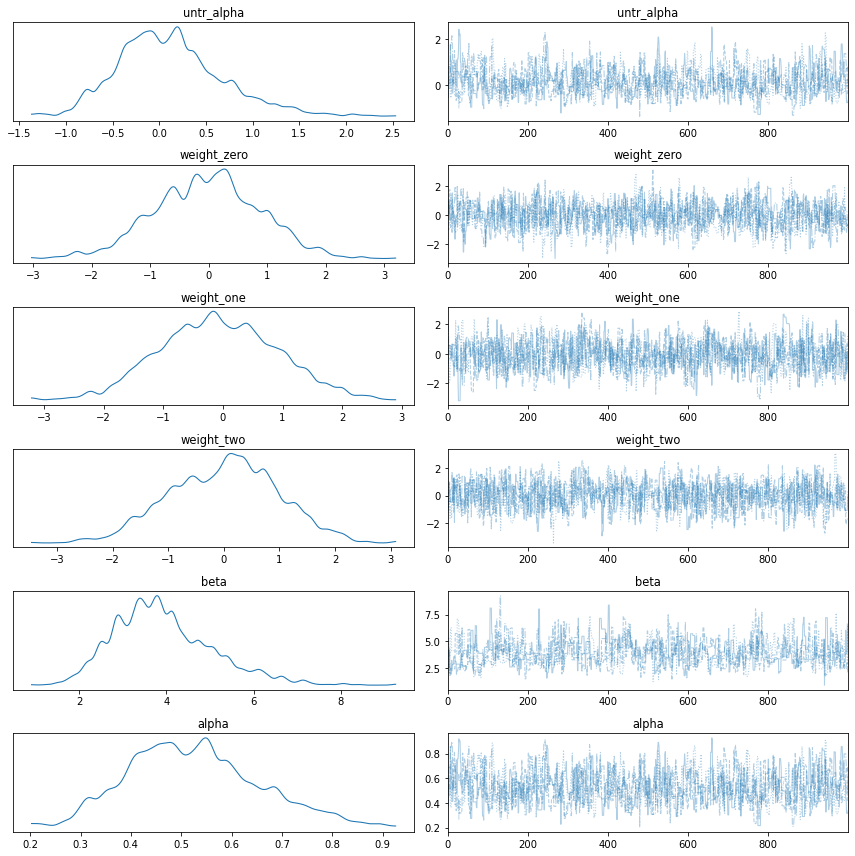

In [83]:
az.plot_trace(p_norm_rw_evrpe_model.traces['other']['558955ebfdf99b6bd06016c9'], combined=True)
plt.tight_layout()

<AxesSubplot:>

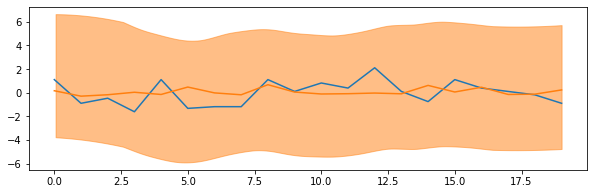

In [84]:
fig = plt.figure(figsize=(10,3))
sns.lineplot(x=np.arange(len(p_norm_rw_evrpe_model.norm_cravings)), y=p_norm_rw_evrpe_model.norm_cravings)
sns.lineplot(
    x=np.arange(len(real)), 
    y=p_norm_rw_evrpe_model.traces['other']['558955ebfdf99b6bd06016c9'].posterior_predictive.craving_like.values[0].mean(axis=0)
)
az.plot_hdi(
    x=np.arange(len(real)), 
    y=p_norm_rw_evrpe_model.traces['other']['558955ebfdf99b6bd06016c9'].posterior_predictive.craving_like,
    hdi_prob=0.4
)

In [85]:
p_norm_rw_ev_model = Passive_Norm_RW_EV(longform, df_summary, project_dir)
p_norm_rw_ev_model.fit(7, 'other')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [untr_alpha]
>Metropolis: [beta]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


<AxesSubplot:>

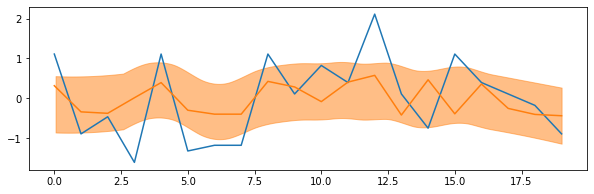

In [86]:
fig = plt.figure(figsize=(10,3))
sns.lineplot(x=np.arange(len(p_norm_rw_ev_model.norm_cravings)), y=p_norm_rw_ev_model.norm_cravings)
sns.lineplot(
    x=np.arange(len(real)), 
    y=p_norm_rw_ev_model.traces['other']['558955ebfdf99b6bd06016c9'].posterior_predictive.craving_like.values[0].mean(axis=0)
)
az.plot_hdi(
    x=np.arange(len(real)), 
    y=p_norm_rw_ev_model.traces['other']['558955ebfdf99b6bd06016c9'].posterior_predictive.craving_like,
    hdi_prob=0.5
)

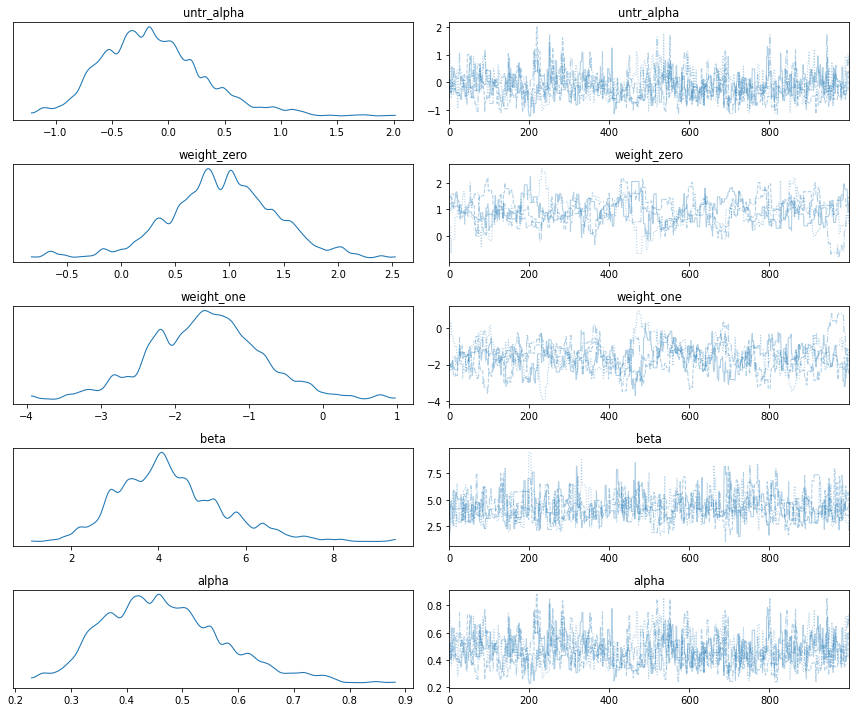

In [75]:
az.plot_trace(p_norm_rw_ev_model.traces['other']['558955ebfdf99b6bd06016c9'], combined=True)
plt.tight_layout()

In [28]:
p_rw_rpe_model = Passive_RW_RPE(longform, df_summary, project_dir)
p_rw_rpe_model.fit(7, 'other')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [untr_alpha]
>Metropolis: [beta]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


In [34]:
p_rwsep_evrpe_model = Passive_RWSeparate_EVRPE(longform, df_summary, project_dir)
p_rwsep_evrpe_model.fit(7, 'other')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [untr_alpha_pos]
>Metropolis: [untr_alpha_neg]
>Metropolis: [beta]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.


In [35]:
p_rwsep_ev_model = Passive_RWSeparate_EV(longform, df_summary, project_dir)
p_rwsep_ev_model.fit(7, 'other')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [untr_alpha_pos]
>Metropolis: [untr_alpha_neg]
>Metropolis: [beta]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


In [36]:
p_rwsep_rpe_model = Passive_RWSeparate_RPE(longform, df_summary, project_dir)
p_rwsep_rpe_model.fit(7, 'other')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [untr_alpha_pos]
>Metropolis: [untr_alpha_neg]
>Metropolis: [beta]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.


## Trace visualization

array([<AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'beta'}>,
       <AxesSubplot:title={'center':'weight_zero'}>,
       <AxesSubplot:title={'center':'weight_one'}>], dtype=object)

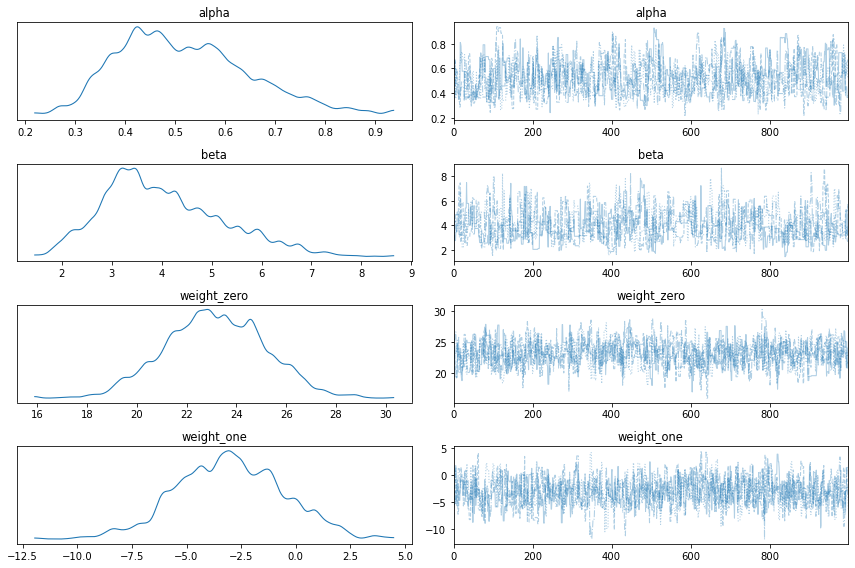

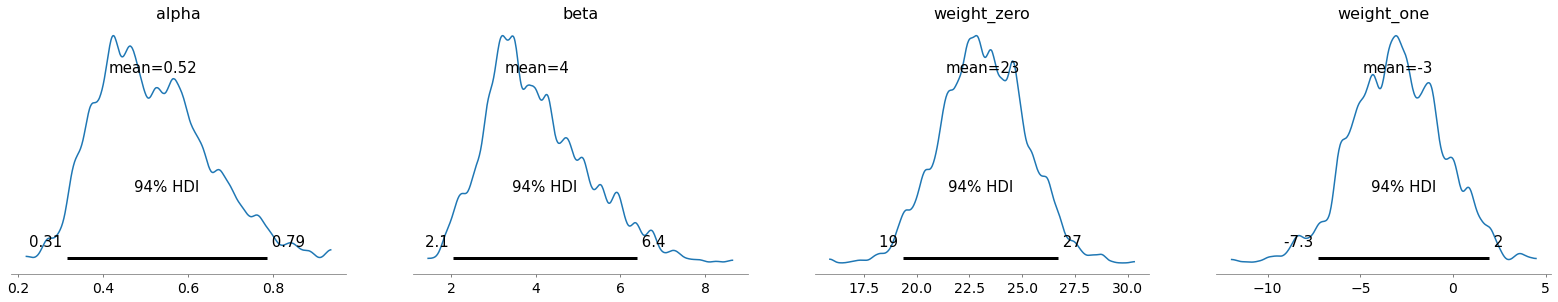

In [37]:
az.plot_trace(p_rw_ev_model.traces['other']['558955ebfdf99b6bd06016c9'], var_names=['alpha', 'beta', 'weight_zero', 'weight_one'], combined=True)
plt.tight_layout()
az.plot_posterior(p_rw_ev_model.traces['other']['558955ebfdf99b6bd06016c9'], var_names=['alpha', 'beta', 'weight_zero', 'weight_one'])

## Model comparison

In [42]:
choice_waic_compare = az.compare({
    'p_rw_evrpe': p_rw_evrpe_model.traces['other']['558955ebfdf99b6bd06016c9'],
    'p_rw_ev': p_rw_ev_model.traces['other']['558955ebfdf99b6bd06016c9'],
    'p_rw_rpe': p_rw_rpe_model.traces['other']['558955ebfdf99b6bd06016c9'],
    'p_rwsep_evrpe': p_rwsep_evrpe_model.traces['other']['558955ebfdf99b6bd06016c9'],
    'p_rwsep_ev': p_rwsep_ev_model.traces['other']['558955ebfdf99b6bd06016c9'],
    'p_rwsep_rpe': p_rwsep_rpe_model.traces['other']['558955ebfdf99b6bd06016c9'],
}, 
var_name='like',
ic='waic')
choice_waic_compare

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
p_rwsep_ev,0,-23.580408,1.284935,0.000000,1.000000e+00,4.156401,0.000000,False,log
p_rwsep_evrpe,1,-23.721187,1.408560,0.140779,1.734723e-16,4.170723,0.044862,False,log
p_rwsep_rpe,2,-23.737437,1.437261,0.157029,0.000000e+00,4.156245,0.075413,False,log
p_rw_rpe,3,-24.382214,1.187066,0.801806,0.000000e+00,4.248103,0.749180,False,log
p_rw_evrpe,4,-24.455444,1.245047,0.875036,0.000000e+00,4.343200,0.781930,False,log
p_rw_ev,5,-24.491767,1.280456,0.911359,0.000000e+00,4.298465,0.764178,False,log


In [43]:
craving_waic_compare = az.compare({
    'p_rw_evrpe': p_rw_evrpe_model.traces['other']['558955ebfdf99b6bd06016c9'],
    'p_rw_ev': p_rw_ev_model.traces['other']['558955ebfdf99b6bd06016c9'],
    'p_rw_rpe': p_rw_rpe_model.traces['other']['558955ebfdf99b6bd06016c9'],
    'p_rwsep_evrpe': p_rwsep_evrpe_model.traces['other']['558955ebfdf99b6bd06016c9'],
    'p_rwsep_ev': p_rwsep_ev_model.traces['other']['558955ebfdf99b6bd06016c9'],
    'p_rwsep_rpe': p_rwsep_rpe_model.traces['other']['558955ebfdf99b6bd06016c9'],
}, 
var_name='craving_like',
ic='waic')
craving_waic_compare

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
p_rw_ev,0,-69.374842,0.394547,0.000000,1.000000e+00,1.056669,0.000000,False,log
p_rwsep_ev,1,-69.418268,0.387537,0.043427,0.000000e+00,1.081499,0.052825,False,log
p_rw_evrpe,2,-69.557443,0.553752,0.182602,0.000000e+00,1.069371,0.046191,False,log
p_rwsep_evrpe,3,-69.607962,0.529023,0.233120,0.000000e+00,1.126156,0.096522,False,log
p_rwsep_rpe,4,-70.286842,0.505761,0.912000,1.882854e-15,1.263414,0.318995,False,log
p_rw_rpe,5,-70.290122,0.512252,0.915281,0.000000e+00,1.246543,0.315345,False,log


<AxesSubplot:xlabel='Log'>

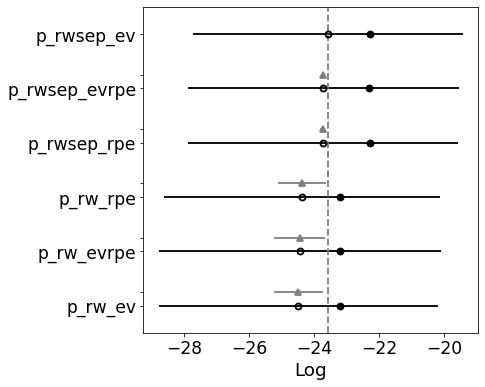

In [44]:
az.plot_compare(choice_waic_compare)

<AxesSubplot:xlabel='Log'>

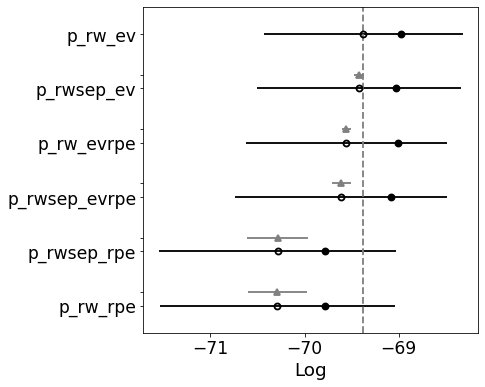

In [45]:
az.plot_compare(craving_waic_compare)